---
title: "优化基础"
---

## 学习目标

本讲将系统介绍数值优化的核心算法与实践技巧。具体目标包括：

* 理解**梯度下降**（Gradient Descent, GD）的数学来源、收敛直觉与**线搜索**策略（固定步长/回溯 Armijo/Wolfe 条件），掌握实用的**停止准则**设计。
* 从二阶泰勒展开严格推导**牛顿法**（Newton's Method），理解其**局部二次收敛**性质（在 Hessian 正定区域），以及为何需要**阻尼/回溯**机制。
* 理解**拟牛顿方法**（Quasi-Newton，以 BFGS 为例）的核心思想——**割线（secant）条件**与曲率条件 $y^\top s>0$ 的作用与几何意义。
* 在**已知可导**损失函数上对比 GD 与牛顿法：绘制**收敛轨迹**与**损失-迭代曲线**，深入观察**初值与学习率**对算法性能的影响。
* （附录）了解**非线性最小二乘**问题的特殊结构、**可微计算图**与自动微分、JAX/Optax 优化器的基本用法与优势/注意事项。

## 动机与应用场景

### 为什么学习数值优化？

前面的课程已经系统学习：

- **求根问题**：寻找 $f(x)=0$ 的解（Newton-Raphson、割线法等）
- **插值与逼近**：用简单函数拟合复杂数据（多项式、样条）
- **数值积分**：计算定积分的近似值（梯形、Simpson）
- **线性代数**：求解线性方程组、特征值问题

而**优化问题** $\min_x f(x)$ 是这些技术的自然延伸和综合应用。从某种意义上说：

- 求根是“寻找导数为零的点”，即 $\nabla f(x) = 0$
- 优化是“寻找函数值最小的点”，通常也满足 $\nabla f(x) = 0$（一阶必要条件）

但优化问题更加复杂：

1. **目标不同**：不是导数为零，而是函数值最小
2. **全局 vs 局部**：可能存在多个局部极小点、鞍点
3. **高维空间**：**机器学习（Machine Learning）**中常涉及百万甚至十亿参数
4. **随机性**：实际数据往往带噪声，需要鲁棒算法

### 典型应用场景

**参数估计与曲线拟合**

给定观测数据 $(t_i, y_i)$，希望用某个参数化模型 $y = m(t; \theta)$ 拟合数据。经典例子：

- **指数衰减**：$y = a e^{-bt}$（放射性衰减、RC 电路充放电）
- **阻尼振子**：$y = A e^{-\gamma t} \cos(\omega t + \phi)$（机械振动、RLC 电路）
- **Logistic 增长**：$y = \displaystyle\frac{K}{1 + e^{-r(t-t_0)}}$（生物种群、疫情传播）

目标函数通常是**最小二乘**：
$$
F(\theta) = \sum_{i=1}^n \big[y_i - m(t_i; \theta)\big]^2
$$

**机器学习训练**

现代机器学习的核心是**经验风险最小化**（Empirical Risk Minimization, ERM）：
$$
\min_{\theta} \frac{1}{n}\sum_{i=1}^n \mathcal{L}(f(x_i; \theta), y_i) + \lambda R(\theta)
$$

其中：

- $\mathcal{L}$ 是损失函数（交叉熵、MSE 等）
- $R(\theta)$ 是正则化项（$L^2$ 范数、$L^1$ 范数等）
- 任务特点：**高维、非凸、随机性强**

::: callout-tip
工程实践中依赖自适应优化器（Adam、RMSProp、AdaGrad 等）配合批量随机梯度（mini-batch SGD）
:::

::: callout-note
**其他应用**

**工程标定与系统辨识**

- **机器人标定**：通过最小化测量误差优化机械臂的 DH 参数
- **控制系统辨识**：从输入–输出数据推断系统传递函数
- **有限元模型修正**：调整材料参数使仿真结果与实验吻合

**物理模拟与能量最小化**

- **分子动力学**：原子位形的势能最小化
- **结构优化**：桁架、梁的形状优化以最小化重量或变形
- **电磁场设计**：天线、波导的几何参数优化
:::

> 我们将以**低维参数拟合**（2D 二次型、指数衰减）为例，兼顾**理论推导**与**可视化直觉**，为理解高维机器学习优化打下基础。

# 一、问题刻画与基本术语

## 数学表述

考虑**无约束优化问题**：
$$
\min_{x \in \mathbb{R}^d} f(x)
$$

其中：

- $f: \mathbb{R}^d \to \mathbb{R}$ 是目标函数（objective function）
- $x$ 是优化变量（decision variable），可以是参数向量
- 我们假设 $f$ 至少**一阶可导**，部分算法需要**二阶可导**

**记号约定**：

- **梯度**（gradient）：$g(x) := \nabla f(x) = \left(\frac{\partial f}{\partial x_1}, \ldots, \frac{\partial f}{\partial x_d}\right)^\top \in \mathbb{R}^d$
- **Hessian 矩阵**（二阶导数矩阵）：$H(x) := \nabla^2 f(x) \in \mathbb{R}^{d \times d}$，其中 $H_{ij} = \frac{\partial^2 f}{\partial x_i \partial x_j}$

## 最优性条件

**一阶必要条件**（First-Order Necessary Condition, FONC）：

若 $x^*$ 是局部极小点，则
$$
\nabla f(x^*) = 0
$$

梯度为零的点才**可能**是极小点（也可能是极大点或鞍点）。

**二阶充分条件**（Second-Order Sufficient Condition, SOSC）：

若 $\nabla f(x^*) = 0$ 且 $\nabla^2 f(x^*) \succ 0$（正定），则 $x^*$ 是**严格局部极小点**。

> **直觉**：梯度为零保证“水平”，Hessian 正定保证“向上凸”（碗状）。

## 凸优化 vs 非凸优化

**凸函数**（Convex Function）：

函数 $f$ 是凸的，如果对任意 $x, y \in \mathbb{R}^d$ 和 $\lambda \in [0,1]$，有
$$
f(\lambda x + (1-\lambda) y) \le \lambda f(x) + (1-\lambda) f(y)
$$

几何意义：函数图像上任意两点之间的线段位于函数图像上方。

**凸优化的优势**：

1. **局部最优 = 全局最优**：任何满足 $\nabla f(x^*) = 0$ 的点都是全局最优解
2. **算法可靠**：梯度下降等简单算法必定收敛到全局最优
3. **理论完善**：收敛速率、最优性间隙等有严格保证

**非凸优化的挑战**：

1. **多个局部极小**：算法可能困在非全局最优的局部极小点
2. **鞍点**（Saddle Point）：$\nabla f(x) = 0$ 但 Hessian 特征值有正有负
3. **平坦区域**（plateau）：梯度很小但远离最优解
4. **初值敏感**：不同起点可能收敛到不同解

::: callout-tip
**实践策略**：

- 多次随机初始化（random restart）
- 使用全局优化方法（模拟退火、遗传算法、粒子群）
- 添加动量（momentum）或正则化帮助逃离局部极小
- 在深度学习中，适当的“非凸性”反而有助于泛化
:::

## 本讲的示例问题

我们将使用两类典型问题进行可视化演示：

1. **二维二次型**：
   $$
   f(x) = \frac{1}{2}x^\top A x - b^\top x, \quad A \succ 0
   $$
   这是最简单的凸优化问题，解析最优解为 $x^* = A^{-1}b$。

2. **非线性最小二乘**：
   $$
   F(\theta) = \frac{1}{2}\sum_{i=1}^n \big[a e^{-b t_i} - y_i\big]^2
   $$
   拟合指数衰减数据，参数 $\theta = (a, b) \in \mathbb{R}^2$，非凸但形状良好。


# 二、梯度下降

GD 是**最基础、最直观**的优化算法，也是理解更复杂方法（SGD、Adam、牛顿法）的起点。

## 基本思想与推导

**方向导数**回顾：

函数 $f$ 在点 $x$ 沿方向 $d$（单位向量）的方向导数为
$$
D f(x)[d] = \lim_{t \to 0^+} \frac{f(x + td) - f(x)}{t} = \nabla f(x)^\top d = g(x)^\top d
$$

**问题**：在哪个方向 $d$ 上，函数下降最快？

通过 Cauchy-Schwarz 不等式：
$$
g^\top d = \|g\| \|d\| \cos\theta \ge -\|g\| \|d\|
$$

当 $d = -\frac{g}{\|g\|}$（即**负梯度方向**）时，$\cos\theta = -1$，下降最快。

**梯度下降迭代公式**：
$$
x_{k+1} = x_k - \alpha_k g_k, \quad g_k := \nabla f(x_k)
$$

其中 $\alpha_k > 0$ 是**步长**（step size）或**学习率**（learning rate）。

::: callout-tip
想象你站在山坡上（函数曲面），想快速下山：

- **梯度**指向山坡最陡上升方向
- **负梯度**指向最陡下降方向
- 每次沿负梯度走一步 $\alpha_k$
:::

## 步长选择策略

步长 $\alpha_k$ 的选择：

**固定步长**（Constant Step Size）：$\alpha_k \equiv \alpha$

- **优点**：简单，无需额外计算
- **缺点**：
  - 太大：振荡、发散（overshooting）
  - 太小：收敛慢（undershooting）
  - 难以找到“恰好”的值

**精确线搜索**（Exact Line Search）：
$$
\alpha_k = \arg\min_{\alpha > 0} f(x_k - \alpha g_k)
$$

- **优点**：理论最优
- **缺点**：每步需要求解一个一维优化问题，计算昂贵

**回溯线搜索**（Backtracking Line Search）：在固定和精确之间的折中方案。

## Armijo 条件

**思想**：从一个较大的初始步长 $\alpha_{\text{init}}$ 开始，如果下降不够充分，就缩小步长。

**Armijo 条件**（Sufficient Decrease Condition）回溯线搜索：
$$
f(x_k - \alpha g_k) \le f(x_k) - c \alpha \|g_k\|^2
$$

其中 $c \in (0, 1)$ 是一个小常数（典型值 $c = 10^{-4}$）。

**几何意义**：

考虑一维情况 $\phi(\alpha) := f(x_k - \alpha g_k)$，在 $\alpha = 0$ 处做一阶 Taylor 展开：
$$
\phi(\alpha) \approx \phi(0) + \phi'(0) \alpha = f(x_k) - \alpha \|g_k\|^2
$$

Armijo 条件要求函数值至少下降到这条切线的 $c$ 倍：
$$
\phi(\alpha) \le \phi(0) + c \phi'(0) \alpha
$$

当 $c = 1$ 时，要求至少达到切线预测的下降；$c < 1$ 时放宽要求。

**算法流程**：

1. 设定 $\alpha \leftarrow \alpha_{\text{init}}$（例如 $\alpha_{\text{init}} = 1$）
2. 如果 Armijo 条件不满足：$\alpha \leftarrow \beta \alpha$（例如 $\beta = 0.5$）
3. 重复步骤 2 直到条件满足或 $\alpha$ 太小

**优点**：

- 保证每步都有足够下降
- 计算开销可控（通常只需几次回溯）
- **自适应调整步长**

## Wolfe 条件

Armijo 条件只保证“足够下降”，但不排除步长过小的情况。**Wolfe 条件**在 Armijo 基础上增加了**曲率条件**（Curvature Condition）。

**强 Wolfe 条件**：

1. **Armijo 条件**：$f(x_k + \alpha_k p_k) \le f(x_k) + c_1 \alpha_k \nabla f(x_k)^\top p_k$
2. **曲率条件**：$|\nabla f(x_k + \alpha_k p_k)^\top p_k| \le c_2 |\nabla f(x_k)^\top p_k|$

其中 $0 < c_1 < c_2 < 1$（典型值：$c_1 = 10^{-4}$, $c_2 = 0.9$），$p_k$ 是搜索方向。

**意义**：

- Armijo：函数值下降足够
- 曲率条件：在新点处梯度在搜索方向上的投影不能太大（防止步长过小）

Wolfe 条件保证 $y_k^\top s_k > 0$，其中：

- $s_k = x_{k+1} - x_k = \alpha_k p_k$
- $y_k = g_{k+1} - g_k$

这个性质对 **BFGS** 等拟牛顿方法很重要，确保曲率矩阵保持正定。

## 停止准则

**为什么设置停止准则？**

1. 数值计算不可能达到理论上的 $\nabla f(x^*) = 0$（机器精度限制）
2. 实际应用中，"足够好"的解已满足需求
3. 需要在精度和计算成本之间权衡

常用停止准则：梯度范数、函数值/参数变化、迭代次数等。

**梯度范数准则**：
$$
\|g_k\| \le \varepsilon_g
$$

- **原理**：一阶最优性条件 $\nabla f(x^*) = 0$
- **典型值**：$\varepsilon_g = 10^{-6}$ 到 $10^{-8}$
- **优点**：直接对应最优性条件
- **缺点**：对函数尺度敏感（可改用相对准则 $\|g_k\| \le \varepsilon_g (1 + |f_k|)$）

**函数值变化准则**：
$$
|f_{k+1} - f_k| \le \varepsilon_f (1 + |f_k|)
$$

- **原理**：函数值不再显著下降
- **典型值**：$\varepsilon_f = 10^{-8}$ 到 $10^{-12}$
- **优点**：对用户更直观（目标是最小化函数值）
- **缺点**：可能在平坦区域过早停止

**参数变化准则**：
$$
\|x_{k+1} - x_k\| \le \varepsilon_x (1 + \|x_k\|)
$$

- **原理**：参数不再显著移动
- **典型值**：$\varepsilon_x = 10^{-6}$ 到 $10^{-10}$
- **缺点**：小步长不代表已达最优（可能步长选择太小）

**迭代次数上限**：
$$
k \ge k_{\max}
$$

- **原理**：防止无限循环
- **典型值**：$k_{\max} = 1000$ 到 $10^5$（视问题规模）

::: callout-tip
**实践建议**：

- **组合使用**多个准则（任一满足即停止）
- **优先级**：梯度范数 > 函数变化 > 参数变化
- **记录**：同时记录所有量，便于事后分析
- **相对 vs 绝对**：用相对准则避免尺度问题
:::

## GD 伪代码：回溯 Armijo

```text
Input: 初始点 x0, 初始步长 α_init, 回溯参数 β∈(0,1), Armijo 参数 c∈(0,1)
       停止阈值 ε_g, 最大迭代次数 max_iter
       (典型值: β=0.5, c=1e-4, ε_g=1e-6)

Initialize: x ← x0, k ← 0

repeat:
  g ← ∇f(x)                          // 计算梯度
  
  if ||g|| < ε_g:                     // 梯度足够小
      break                           // 收敛，停止
  
  α ← α_init                         // 重置步长
  
  // 回溯线搜索
  while f(x - α g) > f(x) - c α ||g||²:
      α ← β α                        // 缩小步长
      if α < α_min:                   // 防止步长过小
          break
  
  x ← x - α g                        // 更新参数
  k ← k + 1
  
  if k ≥ max_iter:                   // 达到最大迭代次数
      break

return x, f(x), ||g||
```

**关键点**：

1. **梯度计算**：可用解析导数、数值差分或自动微分
2. **内层 while 循环**：回溯线搜索，通常只需 1-5 次回溯
3. **外层 repeat 循环**：主迭代，每步沿负梯度前进
4. **多重停止条件**：梯度、迭代次数、步长失效

## 收敛性分析简述

**凸 + Lipschitz 梯度条件**：

若 $f$ 凸且 $\|\nabla f(x) - \nabla f(y)\| \le L\|x - y\|$（梯度 Lipschitz 连续），固定步长 $\alpha \le 1/L$ 的梯度下降满足：
$$
f(x_k) - f(x^*) \le \frac{\|x_0 - x^*\|^2}{2\alpha k}
$$

即 $O(1/k)$ **次线性收敛**（sublinear convergence）。

**强凸条件**：

若额外满足强凸性

$$f(y) \ge f(x) + \nabla f(x)^\top (y-x) + \frac{\mu}{2}\|y-x\|^2$$

则为 $O(\rho^k)$ **线性收敛**（linear convergence），其中 $\rho = (1 - \mu/L) < 1$（条件数 $\kappa = L/\mu$ 越小越快）。

> **直觉**：收敛快慢取决于函数的“形状”（条件数）和算法的“视野”（一阶 vs 二阶信息）。


# 三、牛顿法与阻尼/回溯

梯度下降只用一阶信息（梯度），每步沿固定方向前进。牛顿法利用**二阶信息**（Hessian），能更智能地选择方向和步长。

## 二阶 Taylor 展开与推导

在当前点 $x_k$ 附近，对 $f$ 做**二阶 Taylor 展开**：
$$
f(x_k + s) \approx f(x_k) + g_k^\top s + \frac{1}{2} s^\top H_k s =: m_k(s)
$$

其中：

- $g_k = \nabla f(x_k)$ 是梯度
- $H_k = \nabla^2 f(x_k)$ 是 Hessian 矩阵
- $m_k(s)$ 是 $f$ 在 $x_k$ 的**二次模型**（quadratic model）

**牛顿方向**：最小化二次模型 $m_k(s)$。

对 $s$ 求导并令其为零：
$$
\nabla_s m_k(s) = g_k + H_k s = 0
$$

解得**牛顿步**：
$$
s_k = -H_k^{-1} g_k
$$

**牛顿迭代**：
$$
x_{k+1} = x_k + s_k = x_k - H_k^{-1} g_k
$$

## 几何与直觉

- **梯度下降**：$x_{k+1} = x_k - \alpha g_k$
  - 步长 $\alpha$ 是标量
  - 所有方向统一缩放
  - 如同“近视眼”，只看到梯度方向

- **牛顿法**：$x_{k+1} = x_k - H_k^{-1} g_k$
  - $H_k^{-1}$ 是矩阵
  - 不同方向不同缩放（考虑曲率）
  - 如同“远视眼”，看到局部二次曲面

**例子：轴对齐椭圆**

考虑 $f(x_1, x_2) = \frac{1}{2}(\lambda_1 x_1^2 + \lambda_2 x_2^2)$，其中 $\lambda_1 \gg \lambda_2 > 0$。

- **梯度**：$g = (\lambda_1 x_1, \lambda_2 x_2)^\top$
- **Hessian**：$H = \text{diag}(\lambda_1, \lambda_2)$

梯度下降更新：
$$
x_{k+1} = x_k - \alpha (\lambda_1 x_{k,1}, \lambda_2 x_{k,2})^\top
$$

若选固定 $\alpha$：

- $x_1$ 方向（曲率大）可能过度矫正
- $x_2$ 方向（曲率小）进展缓慢
- 产生“之字形”轨迹

牛顿法更新：
$$
x_{k+1} = x_k - H^{-1}g = x_k - \text{diag}(1/\lambda_1, 1/\lambda_2) \cdot (\lambda_1 x_{k,1}, \lambda_2 x_{k,2})^\top = 0
$$

**一步到达最优解**！（因为这是精确二次函数）

## 局部二次收敛

**定理（局部收敛）**：

若 $f$ 二阶连续可微，$x^*$ 满足 $\nabla f(x^*) = 0$ 且 $\nabla^2 f(x^*) \succ 0$（正定），则存在邻域 $\mathcal{N}(x^*)$ 使得：

1. 从 $x_0 \in \mathcal{N}(x^*)$ 开始，纯牛顿法（无阻尼）收敛到 $x^*$
2. **二次收敛**：$\|x_{k+1} - x^*\| \le C \|x_k - x^*\|^2$

**直觉**：

- 二次收敛 = 每次迭代时，有效数字翻倍
- 例如：$10^{-2} \to 10^{-4} \to 10^{-8} \to 10^{-16}$（3 步达机器精度）
- 对比梯度下降的**线性收敛**：$10^{-2} \to 0.9 \times 10^{-2} \to 0.81 \times 10^{-2} \to \ldots$（需数百步）

**代价**：

- 每步需计算并求解 Hessian：$O(d^3)$ 运算（$d$ 维空间）
- 只在 $x_k$ 接近 $x^*$ 且 $H_k \succ 0$ 时有效

## 全局收敛的挑战

**问题1：Hessian 不正定**

若 $H_k$ 有负特征值：

- $s_k = -H_k^{-1}g_k$ 可能不是下降方向
- 甚至可能 $g_k^\top s_k > 0$（向上走）

**问题2：远离最优解**

二次模型只在局部准确，远离时：

- 步长 $\|s_k\|$ 可能过大
- 函数值不降反升

**解决思路**：阻尼/回溯。

## 阻尼牛顿（Damped Newton）

在牛顿步上乘以步长因子 $\alpha_k \in (0, 1]$：
$$
x_{k+1} = x_k + \alpha_k s_k, \quad s_k = -H_k^{-1}g_k
$$

通过**回溯线搜索**（如 Armijo）选择 $\alpha_k$。

**效果**：

- 当 $x_k$ 远离最优解：$\alpha_k$ 较小，谨慎前进
- 当 $x_k$ 接近最优解：$\alpha_k \to 1$，恢复二次收敛

## Levenberg–Marquardt (LM) 修正

当 $H_k$ 不正定或条件数太大时，修改为：
$$
(H_k + \lambda I) s_k = -g_k
$$

其中 $\lambda > 0$ 是**阻尼参数**（damping parameter）。

**性质**：

- $\lambda = 0$：纯牛顿法
- $\lambda \to \infty$：$s_k \approx -\displaystyle\frac{1}{\lambda}g_k$（梯度下降）
- $\lambda$ 适中：在牛顿与梯度下降间插值

**如何选 $\lambda$**？

1. **Trust region 策略**：根据模型准确度动态调整 $\lambda$
   - 若实际下降 ≈ 模型预测：减小 $\lambda$（更信任牛顿）
   - 若实际下降 < 模型预测：增大 $\lambda$（更保守）

2. **典型更新规则**：
   - 若 $f(x + s)$ 下降好：$\lambda \leftarrow \lambda / 10$
   - 若 $f(x + s)$ 下降差：$\lambda \leftarrow \lambda \times 10$

## 牛顿法的优缺点

**优点**：

1. **收敛快**：二次收敛（局部）
2. **自适应**：自动处理不同方向的曲率差异（ill-conditioning）
3. **理论美**：对二次函数一步到位

**缺点**：

1. **计算代价高**：每步 $O(d^3)$ 求解线性系统
2. **需要 Hessian**：解析计算困难或不可用
3. **数值稳定性**：Hessian 接近奇异时求解不稳定
4. **全局性差**：只在局部有效，需配合线搜索/信赖域

**适用场景**：

- **低维优化**（$d < 1000$）
- Hessian 易于计算（例如，非线性最小二乘）
- 需要高精度解
- 初值较好

**不适用**：

- **高维优化**（深度学习：$d \sim 10^6$ 到 $10^9$）
- Hessian 不可用或计算昂贵
- 非光滑目标（$f$ 不二阶可微）

# 四、拟牛顿方法

拟牛顿法（Quasi-Newton Methods）是**梯度下降**与**牛顿法**的折中：

- 像牛顿法一样利用曲率信息
- 避免计算和存储完整 Hessian
- 通过迭代逐步**“学习”**曲率

## 核心思想

**问题**：我们想用 $B_k \approx H_k$（或其逆 $C_k \approx H_k^{-1}$），但不直接计算 $H_k$。

**策略**：用历史的**梯度变化**和**参数变化**推断曲率。

定义：

- $s_k = x_{k+1} - x_k$：参数步进（step）
- $y_k = g_{k+1} - g_k$：梯度变化（gradient difference）

## 割线条件

**推导**：

若 $f$ 在 $x_k$ 和 $x_{k+1}$ 之间充分光滑，Taylor 展开：
$$
g_{k+1} \approx g_k + H_k s_k
$$

即
$$
y_k \approx H_k s_k
$$

我们希望下一个近似 $B_{k+1}$ 满足**割线条件**（Secant Condition）：
$$
B_{k+1} s_k = y_k
$$

**几何意义**：

- $B_{k+1}$ 对最近一步的曲率信息精确拟合
- 类似差商（finite difference）逼近导数

**问题**：

- 这只是一个方程，但 $B_{k+1}$ 有 $d(d+1)/2$ 个自由度（对称矩阵）
- 需要**额外约束**确定唯一更新

## BFGS 更新公式

**BFGS**（Broyden-Fletcher-Goldfarb-Shanno）是最成功的拟牛顿方法。

给定 $B_k$（对称正定），更新为 $B_{k+1}$，满足：

1. **割线条件**：$B_{k+1}s_k = y_k$
2. **对称性**：$B_{k+1} = B_{k+1}^\top$
3. **最小改变**：$B_{k+1}$ 在 Frobenius 范数意义下最接近 $B_k$

**BFGS 更新公式**（更新 $B_k$）：
$$
B_{k+1} = B_k - \frac{B_k s_k s_k^\top B_k}{s_k^\top B_k s_k} + \frac{y_k y_k^\top}{y_k^\top s_k}
$$

**BFGS 更新公式**（更新 $C_k = B_k^{-1}$，更常用）：
$$
C_{k+1} = \left(I - \frac{s_k y_k^\top}{y_k^\top s_k}\right) C_k \left(I - \frac{y_k s_k^\top}{y_k^\top s_k}\right) + \frac{s_k s_k^\top}{y_k^\top s_k}
$$

**优点**：

- 直接计算 $C_{k+1}$（避免矩阵求逆）
- 复杂度 $O(d^2)$（vs 牛顿法的 $O(d^3)$）

## 曲率条件

BFGS 要求的**曲率条件**：
$$
y_k^\top s_k > 0
$$

**物理意义**：

考虑 $y_k^\top s_k = (g_{k+1} - g_k)^\top (x_{k+1} - x_k)$：

- $s_k$ 是移动方向
- $y_k$ 是该方向上梯度的变化
- 若 $f$ 凸，沿任何方向梯度单调增，故 $y_k^\top s_k \ge 0$

**重要性**：

- 保证 $B_{k+1}$ 或 $C_{k+1}$ 保持**正定**
- 正定性确保搜索方向是**下降方向**

使用 **Wolfe 线搜索**（特别是曲率条件），自动满足 $y_k^\top s_k > 0$。

## BFGS 算法流程

```text
Input: 初始点 x0, 初始 Hessian 逆近似 C0 = I (或 C0 = (1/||g0||)I)

Initialize: x ← x0, C ← C0, k ← 0

repeat:
  g ← ∇f(x)
  
  if ||g|| < ε_g:
      break
  
  // 拟牛顿方向
  p ← -C g
  
  // Wolfe 线搜索
  α ← wolfe_line_search(x, p, ...)
  
  // 更新参数
  x_new ← x + α p
  g_new ← ∇f(x_new)
  
  // 计算 s 和 y
  s ← x_new - x
  y ← g_new - g
  
  // BFGS 更新 C
  if y^T s > 0:
      ρ ← 1 / (y^T s)
      C ← (I - ρ s y^T) C (I - ρ y s^T) + ρ s s^T
  
  x ← x_new
  k ← k + 1

return x
```

## Limited-Memory BFGS (L-BFGS)

**问题**：存储 $C_k$ 需要 $O(d^2)$ 空间，高维时（$d \sim 10^6$）不可行。

**L-BFGS 思想**：

- 不显式存储 $C_k$
- 只存储最近 $m$ 对 $(s_i, y_i)$（如 $m = 10$）
- 通过两次循环（two-loop recursion）隐式计算 $C_k g_k$

**空间复杂度**：$O(md)$（通常 $m \ll d$）

**L-BFGS 是深度学习中常用的二阶优化器**（虽然 Adam 更流行）。

## 拟牛顿 vs 牛顿 vs 梯度下降

| 方法 | 信息 | 每步复杂度 | 存储 | 收敛速率 | 适用场景 |
|------|------|----------|------|---------|---------|
| GD | 一阶（梯度） | $O(d)$ | $O(d)$ | 次线性/线性 | 高维、简单 |
| 牛顿 | 二阶（Hessian） | $O(d^3)$ | $O(d^2)$ | 二次（局部） | 低维、高精度 |
| BFGS | 拟二阶 | $O(d^2)$ | $O(d^2)$ | 超线性 | 中低维、可微 |
| L-BFGS | 拟二阶 | $O(md)$ | $O(md)$ | 超线性 | 高维、可微 |

::: callout-note
**超线性收敛**（Superlinear）：介于线性与二次之间，$\lim_{k\to\infty} \displaystyle\frac{\|x_{k+1}-x^*\|}{\|x_k-x^*\|} = 0$。
:::

# 五、可视化演示

## 例 1：二维二次型

我们用二次函数 $f(x)=\displaystyle\frac{1}{2} x^\top A x - b^\top x$（$A\succ0$）对比 GD 与牛顿。

**性质**：

- **凸函数**（$A \succ 0$）
- **唯一全局最优解**：$x^* = A^{-1}b$（通过 $\nabla f(x^*) = Ax^* - b = 0$）
- **梯度**：$g(x) = Ax - b$（线性）
- **Hessian**：$H(x) = A$（常数）

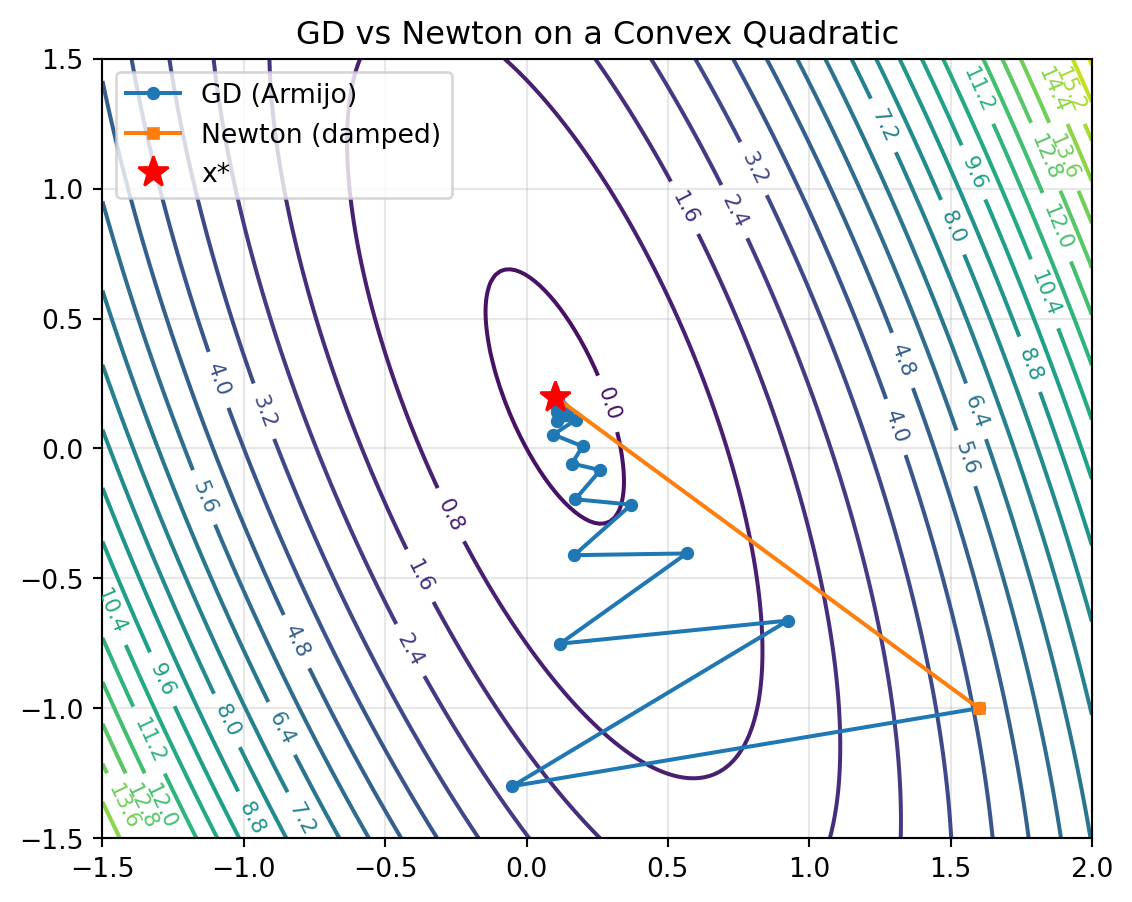

In [1]:
import numpy as np, matplotlib.pyplot as plt

A = np.array([[6.0, 2.0], [2.0, 1.5]])  # 对称正定矩阵
b = np.array([1.0, 0.5])


def f(x):
    """目标函数"""
    return 0.5 * x @ A @ x - b @ x


def g(x):
    """梯度"""
    return A @ x - b


def H(x):
    """Hessian（这里是常数）"""
    return A


def backtracking(x, p, f, g, alpha0=1.0, beta=0.5, c=1e-4):
    """Armijo 回溯线搜索"""
    alpha = alpha0
    fx = f(x)
    gx = g(x)
    while f(x + alpha * p) > fx + c * alpha * gx.dot(p):
        alpha *= beta
        if alpha < 1e-12:
            break
    return alpha


def run_gd(x0, maxit=50, tol=1e-8):
    """梯度下降（带 Armijo 线搜索）"""
    xs = [x0.copy()]
    x = x0.copy()
    for k in range(maxit):
        gn = g(x)
        if np.linalg.norm(gn) < tol:
            break
        p = -gn  # 负梯度方向
        a = backtracking(x, p, f, g, alpha0=1.0)
        x = x + a * p
        xs.append(x.copy())
    return np.array(xs)


def run_newton(x0, maxit=20, tol=1e-10, damp=True):
    """牛顿法（带阻尼）"""
    xs = [x0.copy()]
    x = x0.copy()
    for k in range(maxit):
        gn = g(x)
        if np.linalg.norm(gn) < tol:
            break
        s = -np.linalg.solve(H(x), gn)  # 牛顿方向
        a = backtracking(x, s, f, g, alpha0=1.0) if damp else 1.0
        x = x + a * s
        xs.append(x.copy())
    return np.array(xs)


# 运行算法
x0 = np.array([1.6, -1.0])  # 初始点
gd_path = run_gd(x0)
nt_path = run_newton(x0)

# 绘制等高线 + 优化轨迹
xx = np.linspace(-1.5, 2.0, 200)
yy = np.linspace(-1.5, 1.5, 200)
X, Y = np.meshgrid(xx, yy)
Z = 0.5 * (A[0, 0] * X**2 + 2 * A[0, 1] * X * Y + A[1, 1] * Y**2) - (
    b[0] * X + b[1] * Y
)

plt.figure(figsize=(6, 4.8))
cs = plt.contour(X, Y, Z, levels=25)
plt.clabel(cs, inline=1, fontsize=8, fmt="%.1f")
plt.plot(gd_path[:, 0], gd_path[:, 1], "-o", ms=4, label="GD (Armijo)")
plt.plot(nt_path[:, 0], nt_path[:, 1], "-s", ms=4, label="Newton (damped)")
x_star = np.linalg.solve(A, b)
plt.plot([x_star[0]], [x_star[1]], "r*", ms=12, label="x*")
plt.legend()
plt.title("GD vs Newton on a Convex Quadratic")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

> 观察：
>
> - GD 的“之”字形往等高线短轴方向靠拢
> - 牛顿则一步直达，配合回溯确保全局下降


## 例 2：带噪指数衰减拟合
### 问题背景

**指数衰减模型**在物理/工程中极为常见：

- **放射性衰减**：$N(t) = N_0 e^{-\lambda t}$
- **RC 电路放电**：$V(t) = V_0 e^{-t/RC}$
- **药物代谢**：血液中药物浓度 $C(t) = C_0 e^{-k t}$
- **热传导**：物体温度 $T(t) = T_{\infty} + (T_0 - T_{\infty})e^{-kt}$

**数据拟合**：

给定带噪声测量 $(t_i, y_i)$，拟合模型：
$$
y = a e^{-bt}
$$

参数 $\theta = (a, b) \in \mathbb{R}^2$，其中：

- $a > 0$：初始幅度
- $b > 0$：衰减率

**损失函数**（最小二乘）：
$$
F(\theta) = \frac{1}{2}\sum_{i=1}^n \big[a e^{-b t_i} - y_i\big]^2
$$

**非凸性**：

尽管是最小二乘问题，由于模型 $m(t; \theta) = a e^{-bt}$ 对 $\theta$ **非线性**，$F(\theta)$ 是**非凸**的！

- 可能有多个局部极小（虽然通常只有一个主要的）
- 初值选择影响收敛结果

### 生成模拟数据

In [2]:
rng = np.random.default_rng(0)
n = 60
t = np.linspace(0, 2.0, n)
a_true, b_true = 2.0, 1.3
y = a_true * np.exp(-b_true * t) + 0.05 * rng.standard_normal(n)

def model(theta, t): 
    """指数衰减模型"""
    a, b = theta
    return a * np.exp(-b * t)

def loss(theta):
    """最小二乘损失"""
    r = model(theta, t) - y
    return 0.5 * np.dot(r, r)

**数据特点**：

- 60 个采样点，时间范围 $[0, 2]$
- 真实参数：$a = 2.0$, $b = 1.3$
- 噪声水平：$\sigma = 0.05$（标准差）

### 数值梯度与 Hessian

由于模型的梯度和 Hessian 解析表达式较复杂，这里用**数值差分**：

In [3]:
def numgrad(fun, x, eps=1e-6):
    """中心差分计算梯度"""
    x = np.array(x, float)
    g = np.zeros_like(x)
    for i in range(x.size):
        e = np.zeros_like(x)
        e[i] = 1.0
        g[i] = (fun(x + eps*e) - fun(x - eps*e)) / (2*eps)
    return g

def numhess(fun, x, eps=1e-5):
    """数值二阶差分计算 Hessian"""
    x = np.array(x, float)
    n = x.size
    H = np.zeros((n, n))
    f0 = fun(x)
    for i in range(n):
        ei = np.zeros(n)
        ei[i] = 1.0
        for j in range(i, n):
            ej = np.zeros(n)
            ej[j] = 1.0
            if i == j:
                # 对角元：二阶导数
                fpp = fun(x + eps*ei) - 2*f0 + fun(x - eps*ei)
                H[i,i] = fpp / (eps**2)
            else:
                # 非对角元：混合偏导
                fpp = fun(x + eps*ei + eps*ej) - fun(x + eps*ei - eps*ej) \
                    - fun(x - eps*ei + eps*ej) + fun(x - eps*ei - eps*ej)
                H[i,j] = H[j,i] = fpp / (4*eps**2)
    return H

::: callout-warning
实际应用应使用**自动微分**（如 JAX、PyTorch）或**解析导数**，数值差分仅用于教学演示。
:::

### 优化算法实现

In [4]:
def armijo_step(x, p, f, gfun, alpha0=1.0, beta=0.5, c=1e-4):
    """Armijo 回溯线搜索"""
    a = alpha0
    fx = f(x)
    gx = gfun(x)
    while f(x + a*p) > fx + c*a*gx.dot(p):
        a *= beta
        if a < 1e-12: 
            break
    return a

def run_gd_loss(x0, maxit=200, tol=1e-8, alpha0=1.0):
    """梯度下降优化损失函数"""
    xs = [x0.copy()]
    fs = [loss(x0)]
    x = x0.copy()
    for k in range(maxit):
        gk = numgrad(loss, x)
        if np.linalg.norm(gk) < tol: 
            break
        p = -gk
        a = armijo_step(x, p, loss, lambda z: numgrad(loss, z), alpha0=alpha0)
        x = x + a*p
        xs.append(x.copy())
        fs.append(loss(x))
    return np.array(xs), np.array(fs)

def run_newton_loss(x0, maxit=50, tol=1e-8, damp=True, lm=0.0):
    """牛顿法优化损失函数（可选 LM 阻尼）"""
    xs = [x0.copy()]
    fs = [loss(x0)]
    x = x0.copy()
    for k in range(maxit):
        gk = numgrad(loss, x)
        if np.linalg.norm(gk) < tol: 
            break
        Hk = numhess(loss, x)
        if lm > 0: 
            Hk = Hk + lm * np.eye(len(x))     # Levenberg-Marquardt 阻尼
        try:
            s = -np.linalg.solve(Hk, gk)
        except np.linalg.LinAlgError:
            # Hessian 奇异，退化为梯度方向
            s = -gk
        a = armijo_step(x, s, loss, lambda z: numgrad(loss, z), alpha0=1.0) if damp else 1.0
        x = x + a*s
        xs.append(x.copy())
        fs.append(loss(x))
    return np.array(xs), np.array(fs)

# 运行优化
x0 = np.array([1.0, 0.2])   # 初始猜测
gd_path, gd_fs = run_gd_loss(x0, alpha0=1.0)
nt_path, nt_fs = run_newton_loss(x0, lm=1e-6)   # 轻微 LM 阻尼

print("GD final θ:", gd_path[-1], "  f=", gd_fs[-1])
print("NT final θ:", nt_path[-1], "  f=", nt_fs[-1])

GD final θ: [1.9863909 1.2842715]   f= 0.0600918897666034
NT final θ: [1.9863909 1.2842715]   f= 0.060091889766603436


### 结果可视化

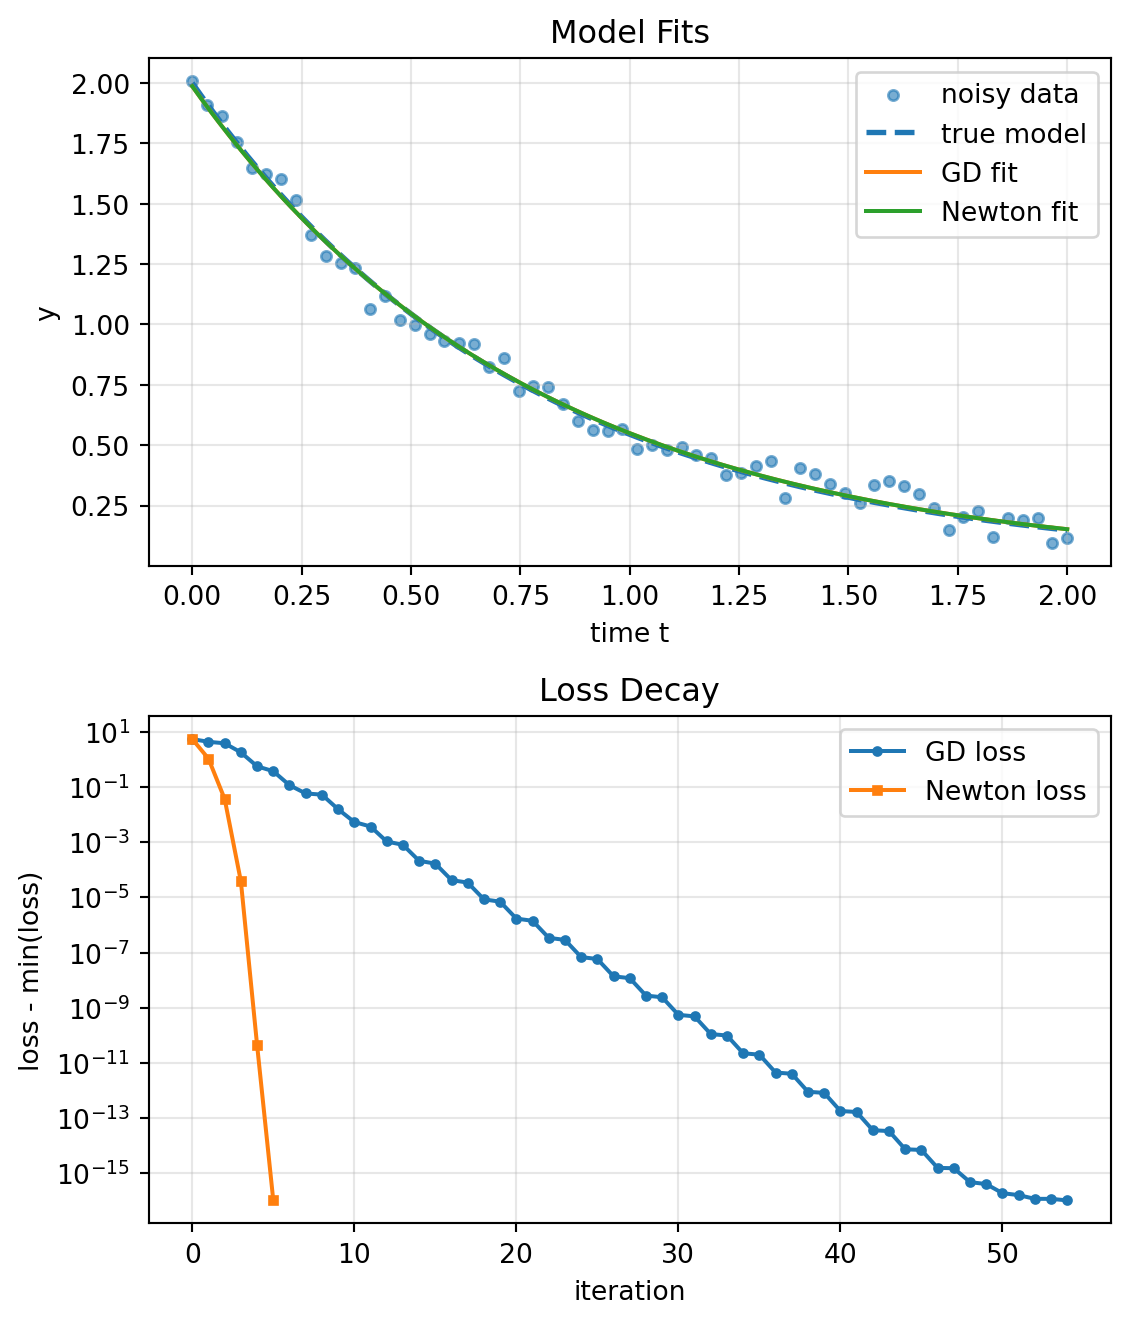

In [5]:
# 生成拟合曲线
tt = np.linspace(t.min(), t.max(), 400)
y_gd = model(gd_path[-1], tt)
y_nt = model(nt_path[-1], tt)
y_true = model([a_true, b_true], tt)

fig, ax = plt.subplots(2, 1, figsize=(6, 7))

# 左图：数据与拟合曲线
ax[0].scatter(t, y, s=15, alpha=0.6, label="noisy data")
ax[0].plot(tt, y_true, '--', lw=2, label="true model")
ax[0].plot(tt, y_gd, label="GD fit")
ax[0].plot(tt, y_nt, label="Newton fit")
ax[0].set_xlabel("time t")
ax[0].set_ylabel("y")
ax[0].set_title("Model Fits")
ax[0].legend()
ax[0].grid(alpha=0.3)

# 右图：损失函数收敛曲线（对数尺度）
ax[1].semilogy(gd_fs - gd_fs.min() + 1e-16, "-o", ms=3, label="GD loss")
ax[1].semilogy(nt_fs - nt_fs.min() + 1e-16, "-s", ms=3, label="Newton loss")
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("loss - min(loss)")
ax[1].set_title("Loss Decay")
ax[1].grid(True, which="both", alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

### 观察与分析

**拟合质量**（上图）：

- 两种方法都成功拟合数据
- 拟合曲线与真实曲线几乎重合
- 说明优化达到了较好的解

**收敛速度**（下图）：

- **牛顿法**：
  - 前几步损失快速下降（陡峭）
  - 约 10 步达到机器精度
  - 后期呈二次收敛（直线下降）

- **梯度下降**：
  - 初期也下降较快
  - 中后期变慢（对数坐标下变平缓）
  - 需要更多迭代达到相同精度

**参数估计**：

打印输出显示两种方法得到的参数接近真实值 $(2.0, 1.3)$，且彼此接近。

**实践启示**：

1. 对于形状良好的非线性最小二乘，牛顿类方法显著优于 GD
2. 但牛顿法对初值更敏感（若初值太差可能不收敛）
3. 数值差分的 Hessian 计算昂贵且不精确，实际应用中应避免

## 超参数敏感性：步长扫描

梯度下降的性能对**学习率**（步长）$\alpha$ 极为敏感。我们通过两个对比实验深入探索这一现象。

### 实验设计

**目标**：对不同学习率 $\alpha$，记录达到收敛所需的迭代次数。

**基本设定**：

- 停止准则：$\|\nabla F(\theta)\| < 10^{-8}$
- 最大迭代：500
- 学习率范围：对数均匀采样
- 使用**固定步长**GD（无线搜索），以突出学习率选择的重要性

我们将对比**凸问题**（二次型）和**非凸问题**（指数衰减拟合）的行为差异。

### 实验A：凸二次型（经典U型曲线）

首先考虑**二维二次型**：
$$
f(x) = \frac{1}{2}x^\top A x - b^\top x, \quad A = \begin{pmatrix} 6 & 2 \\ 2 & 1.5 \end{pmatrix}
$$

这是一个**严格凸**问题，有唯一全局最优解。

In [6]:
# 凸二次型的梯度下降
A = np.array([[6., 2.], [2., 1.5]])
b = np.array([1., 0.5])

def f_quad(x): 
    return 0.5*x@A@x - b@x

def g_quad(x): 
    return A@x - b

def gd_iters_quad(lr, x0=np.array([1.6, -1.0]), maxit=500):
    """固定学习率GD，返回收敛所需迭代次数"""
    x = x0.copy()
    for k in range(maxit):
        gk = g_quad(x)
        if np.linalg.norm(gk) < 1e-8:
            return k
        x = x - lr * gk
        if not np.isfinite(f_quad(x)):  # 发散检测
            return np.inf
    return np.inf

# 扫描不同学习率
lrs_quad = np.logspace(-2, 0.5, 20)  # 0.01 到 ~3.16
iters_quad = [gd_iters_quad(lr) for lr in lrs_quad]

/Users/macops/edu/numerical-methods-2025/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2792: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)
/var/folders/rr/08x40lhj1s566qkls2cdd0400000gn/T/ipykernel_30915/1383103500.py:6: RuntimeWarning: overflow encountered in matmul
  return 0.5*x@A@x - b@x


### 实验B：非线性最小二乘（非凸复杂性）

使用**指数衰减拟合**问题：
$$
F(\theta) = \frac{1}{2}\sum_{i=1}^n \big[a e^{-b t_i} - y_i\big]^2
$$

这是一个**非凸**问题，优化地形更加复杂。

In [7]:
# 非线性最小二乘的梯度下降
def gd_iters_nls(lr, x0=np.array([1.0, 0.2]), maxit=500):
    """固定学习率GD用于非线性最小二乘"""
    x = x0.copy()
    for k in range(maxit):
        gk = numgrad(loss, x)
        if np.linalg.norm(gk) < 1e-8:
            return k
        x = x - lr * gk
        if not np.isfinite(loss(x)): 
            return np.inf
    return np.inf

lrs_nls = np.logspace(-3, 1, 15)
iters_nls = [gd_iters_nls(lr) for lr in lrs_nls]

### 可视化对比

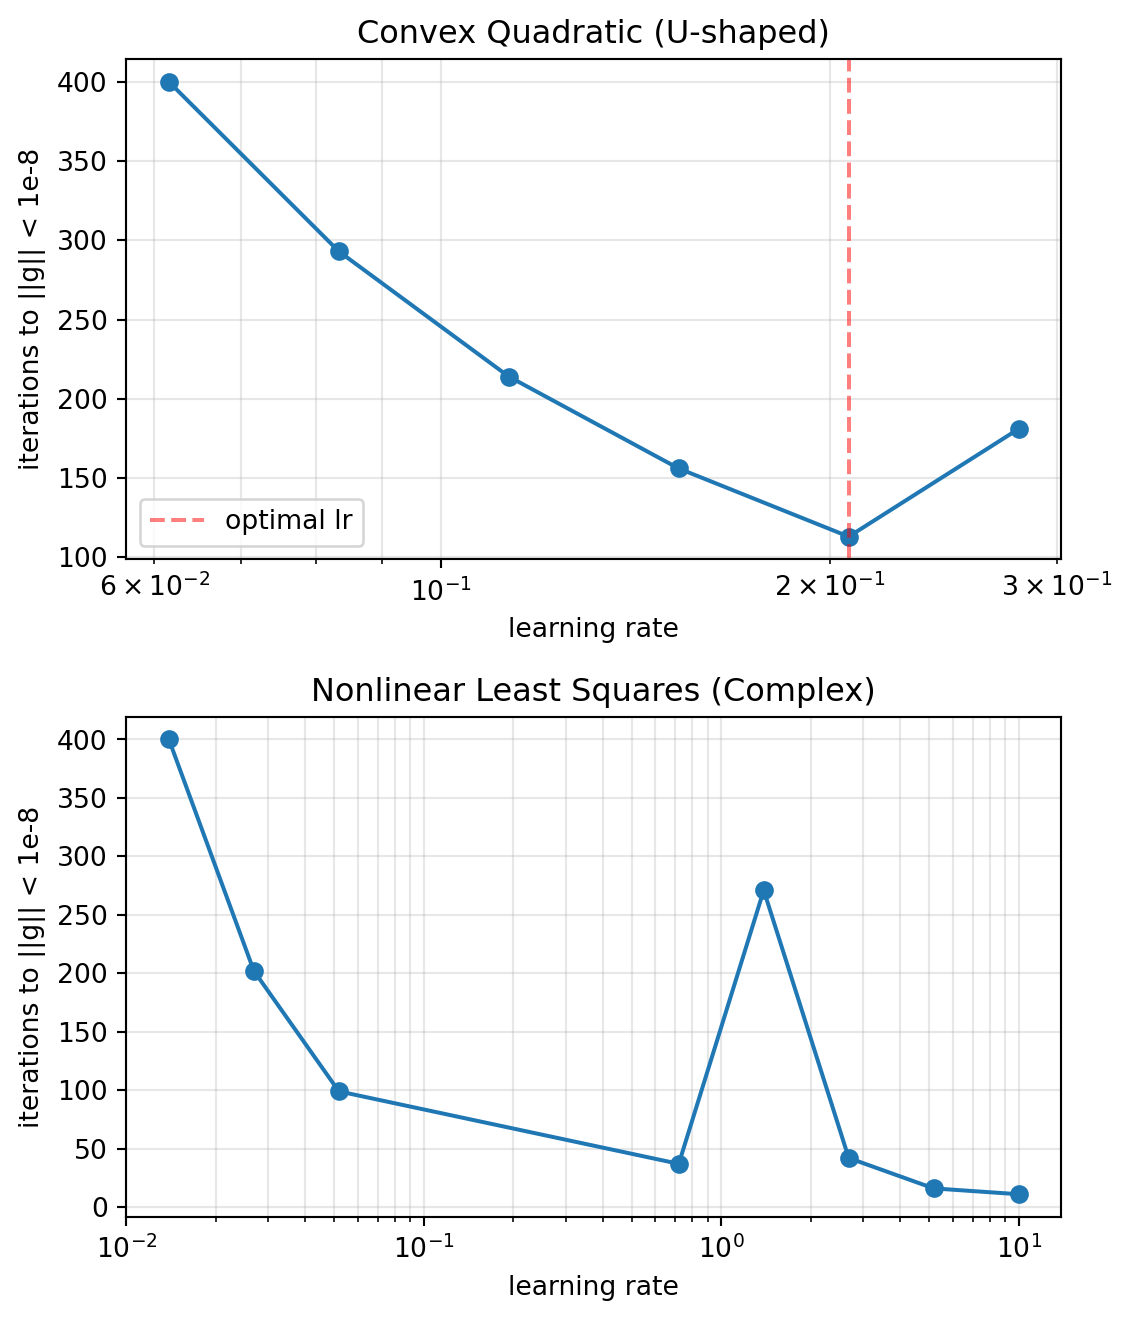

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(6, 7))

# 凸问题
mask_quad = np.isfinite(iters_quad)
axes[0].semilogx(np.array(lrs_quad)[mask_quad], 
                 np.array(iters_quad)[mask_quad], "-o", ms=6)
axes[0].set_xlabel("learning rate")
axes[0].set_ylabel("iterations to ||g|| < 1e-8")
axes[0].set_title("Convex Quadratic (U-shaped)")
axes[0].grid(True, which="both", alpha=0.3)
axes[0].axvline(x=lrs_quad[mask_quad][np.argmin(np.array(iters_quad)[mask_quad])], 
                color='r', linestyle='--', alpha=0.5, label='optimal lr')
axes[0].legend()

# 非凸问题
mask_nls = np.isfinite(iters_nls)
axes[1].semilogx(np.array(lrs_nls)[mask_nls], 
                 np.array(iters_nls)[mask_nls], "-o", ms=6)
axes[1].set_xlabel("learning rate")
axes[1].set_ylabel("iterations to ||g|| < 1e-8")
axes[1].set_title("Nonlinear Least Squares (Complex)")
axes[1].grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()

### 结果分析与对比

#### 凸问题：经典U型

**曲线特征**：

- **清晰的U型**：存在明确的最优学习率
- **左侧**（$\alpha$ 太小，如 $\alpha < 0.05$）：收敛极慢，每步移动不足
- **底部**（甜点区，如 $0.1 \le \alpha \le 0.3$）：快速收敛，迭代次数最少
- **右侧**（$\alpha$ 太大，如 $\alpha > 0.5$）：振荡加剧甚至发散

**理论解释**：

对于二次型 $f(x) = \frac{1}{2}x^\top Ax - b^\top x$，固定步长GD的收敛速率由条件数 $\kappa(A)$ 和学习率决定：

- 最优学习率：$\alpha^* \approx \displaystyle\frac{2}{\lambda_{\max} + \lambda_{\min}}$
- 在 $\alpha^*$ 附近，收敛最快
- 偏离 $\alpha^*$，性能单调下降

#### 非凸问题：复杂地形

**曲线特征**：

- **多峰多谷**：不是简单的U型，可能出现“W型”或更复杂形状
- **峰值**（如 $\alpha \sim 1.5$）：某些学习率导致严重振荡，收敛极慢
- **不规则性**：相邻学习率的性能差异可能很大

**原因分析**：

1. **非凸性**：
   - 存在多个局部极小点、鞍点
   - 不同学习率可能收敛到不同的局部最优解
   - 优化路径对初始步长极其敏感

2. **地形变化**：
   - 损失函数曲率（Hessian特征值）在不同区域差异巨大
   - 某些学习率恰好“触发”困难区域（梯度变化剧烈的狭窄峡谷）
   - 固定步长无法适应地形变化

3. **振荡模式**：
   - 过大的学习率在某些方向产生持续振荡
   - 由于非凸性，这种振荡不一定导致发散，但显著延长收敛时间

::: callout-important
**凸问题**（理想情况）：

- 学习率敏感性**可预测**：U型曲线，存在明确最优区间
- **全局收敛性**：任何合理学习率最终都到达同一全局最优解
- **理论指导**：可通过条件数等性质估计最优学习率

**非凸问题**（现实挑战）：

- 学习率敏感性**不规则**：曲线复杂，难以预测
- **局部收敛性**：不同学习率可能到达不同局部极小点
- **需要自适应策略**：固定学习率可能陷入困境
:::

### 实践指南

基于上述对比，实际优化中的策略：

**对于凸问题**：

1. **网格搜索**：在对数尺度扫描学习率，找到U型底部
2. **理论估计**：用 $\alpha \approx 1/L$（$L$ 是梯度Lipschitz常数）作为起点
3. **固定步长可行**：找到好的学习率后，可以全程使用

**对于非凸问题**（推荐方案）：

1. **避免固定步长**：用**线搜索**（Armijo、Wolfe）自动调整
2. **自适应优化器**：

   - **Adam**：结合动量与自适应学习率，对初始学习率鲁棒
   - **RMSProp**：per-parameter 学习率缩放
   - **SGD + Momentum**：加速并平滑优化路径

3. **学习率调度**：

   - **Warm-up**：初期用小学习率探索，逐步增大
   - **Decay**：后期逐步减小学习率精细调优
   - **Cosine annealing**：周期性调整，帮助跳出局部极小

4. **多次随机初始化**：从不同起点运行，选择最佳结果

> **深度学习实践**：Adam + Cosine 调度是当前主流组合。

### 与线搜索的关联

前面我们实现的**回溯线搜索**（Armijo）正是为了解决上述问题：

```python
# 对比：固定步长 vs 线搜索
x_fixed = run_gd_fixed(x0, alpha=0.1)    # 固定步长（可能不佳）
x_armijo = run_gd(x0)                    # Armijo线搜索（自适应）
```

**线搜索的优势**：

- **自动调整**：每步根据局部地形选择合适步长
- **全局收敛保证**：Armijo条件确保单调下降
- **鲁棒性**：对初始学习率不敏感（只影响计算效率，不影响收敛性）

**代价**：

- 每步需要额外的函数求值
- 但对于复杂非凸问题，这点代价是值得的


::: callout-tip
- **凸问题**：存在明确的“甜点区间”，学习率在此范围内收敛快且稳定
- **非凸问题**：“甜点”难以预测，甚至不存在，需要自适应机制
- **深度学习**：Adam等优化器的成功，正是因为它们能自动适应复杂的非凸地形
:::


# 课后作业

## 回顾

* GD：一阶信息 + 线搜索，稳健但对步长敏感；
* 牛顿：二阶信息，局部二次收敛，但需**阻尼/回溯与正定性修正**；
* 拟牛顿：用迭代构造的曲率近似折中精度与代价；
* **数据拟合**中推荐 GN/LM

### a7-1（必做）：简答

写出梯度下降（GD）与牛顿法的更新公式，并用一句话说明各自方向来源与（局部）收敛速度差异。

### a7-2（必做）：简答

给出 Armijo 条件的数学式，并说明它在实践中避免了什么问题。

### a7-3（选做）：编程

在**带噪指数衰减拟合**上，比较 **GD（带回溯 Armijo）** 与 **阻尼牛顿法** 的收敛表现。

* 数据直接使用这组，不需读文件：

  ```python
  import numpy as np
  rng = np.random.default_rng(0)
  n = 60
  t = np.linspace(0, 2.0, n)
  a_true, b_true = 2.0, 1.3
  y = a_true*np.exp(-b_true*t) + 0.05*rng.standard_normal(n)
  ```

* 模型与损失：
  $$
  \hat y(t;\theta)=a\,e^{-b t},\quad \theta=(a,b),\qquad
  F(\theta)=\tfrac12\sum_i(\hat y(t_i;\theta)-y_i)^2.
  $$
* 要求分别实现：

  1. **GD + 回溯 Armijo**（自己写一个 `backtracking`），梯度用**数值差分**（中央差分）；
  2. **阻尼牛顿法**（牛顿步 + 回溯，Hessian 亦可用**数值差分**或 Gauss–Newton 近似 $J^\top J$）。
* **统一的停止准则**（任取其二即可）：
  $\|\nabla F(\theta_k)\|\le 10^{-6}$ 或 $\|F_{k+1}-F_k\|\le 10^{-9}(1+F_k)$ 或迭代上限（GD 300 步、牛顿 50 步）。
* **初值与敏感性**：至少测试两组初值，例如 $\theta^{(0)}_1=(1.0,0.2)$、$\theta^{(0)}_2=(0.5, 1.8)$。

**交付物：**

1. 代码（含固定的随机种子）；
2. 两张图：

   * 模型**拟合图**：散点 $(t,y)$、真曲线 $2e^{-1.3 t}$、GD和牛顿的最终拟合曲线；
   * **半对数**损失曲线：$\log(F_k-F_{\min}+10^{-16})$ 随迭代步变化，GD 与牛顿同图对比
3. 一页以内的**简短结论**：比较两法的步数、最终损失、对初值的敏感性，指出线搜索是否避免了发散/震荡。


## 附录 A：JAX 可微与 Optax 优化器

> 本课程不涉及 GPU；如使用 JAX，请在 CPU 环境启用 64-bit：
>
> ```python
> import jax, jax.numpy as jnp
> jax.config.update("jax_enable_x64", True)
> ```

### A.1 JAX-grad 对比数值差分

In [9]:
try:
    import jax, jax.numpy as jnp
    jax.config.update("jax_enable_x64", True)

    t_j = jnp.array(t); y_j = jnp.array(y)

    def model_j(theta, t): 
        a, b = theta
        return a*jnp.exp(-b*t)

    def loss_j(theta):
        r = model_j(theta, t_j) - y_j
        return 0.5*jnp.dot(r, r)

    grad_j = jax.grad(loss_j)
    theta = jnp.array([1.0, 0.2])
    # 比较
    grad_num = numgrad(loss, np.array(theta))
    grad_auto = grad_j(theta)
    
    print("数值梯度:", grad_num)
    print("自动微分:", np.array(grad_auto))
    print("误差:", np.linalg.norm(grad_num - np.array(grad_auto)))
    
except Exception as e:
    print("JAX not available or error:", e)

数值梯度: [  2.76006685 -14.23892884]
自动微分: [  2.76006685 -14.23892884]
误差: 2.0164178660528566e-10


### A.2 Optax 示例：SGD vs Adam

**Optax** 提供标准优化器的即插即用实现。

**核心概念**：

1. **优化器**（Optimizer）：如 SGD、Adam、RMSProp
2. **优化器状态**（Optimizer State）：保存动量、二阶矩等
3. **梯度变换**（Gradient Transformation）：可链接的梯度处理模块

**基本用法**：

```python
import optax

# 创建优化器
optimizer = optax.adam(learning_rate=0.01)

# 初始化状态
opt_state = optimizer.init(params)

# 优化循环
for step in range(num_steps):
    # 计算梯度
    grads = jax.grad(loss_fn)(params)
    
    # 更新参数
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
```

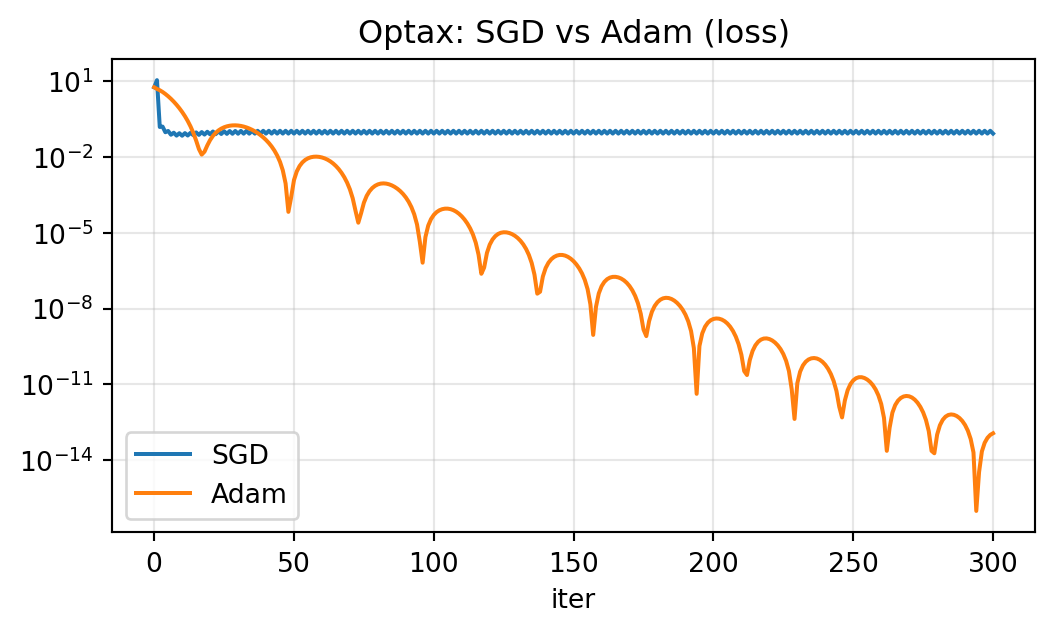

In [10]:
try:
    import optax

    def train_optax(theta0, optimizer, steps=500):
        opt_state = optimizer.init(theta0)
        def step(theta, state):
            g = grad_j(theta)
            updates, state = optimizer.update(g, state, theta)
            theta = optax.apply_updates(theta, updates)
            return theta, state, loss_j(theta)

        thetas=[theta0]; losses=[loss_j(theta0)]
        theta=theta0; state=opt_state
        for _ in range(steps):
            theta, state, fval = step(theta, state)
            thetas.append(theta); losses.append(fval)
        return jnp.stack(thetas), jnp.stack(losses)

    th0 = jnp.array([1.0, 0.2])
    opt_sgd  = optax.sgd(learning_rate=0.1, momentum=0.0)
    opt_adam = optax.adam(learning_rate=0.1)
    th_sgd,  fs_sgd  = train_optax(th0, opt_sgd,  steps=300)
    th_adam, fs_adam = train_optax(th0, opt_adam, steps=300)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(5.6,3.4))
    plt.semilogy(np.array(fs_sgd - fs_adam.min() + 1e-16), label="SGD")
    plt.semilogy(np.array(fs_adam - fs_adam.min() + 1e-16), label="Adam")
    plt.title("Optax: SGD vs Adam (loss)"); plt.xlabel("iter"); plt.grid(True, which="both", alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Optax not available or skipped:", e)

> 读图：Adam 常在初期更快、更稳健，对学习率敏感度较低；但最终精度、泛化与任务相关，需调参与正则。


## 附录 B：非线性最小二乘与 Gauss-Newton/LM 方法

### B.1 问题结构

**非线性最小二乘**（Nonlinear Least Squares, NLS）有特殊结构：

$$
F(\theta) = \frac{1}{2}\|r(\theta)\|^2 = \frac{1}{2}\sum_{i=1}^n r_i(\theta)^2
$$

其中 $r: \mathbb{R}^d \to \mathbb{R}^n$ 是**残差函数**（residual function）。

**例子**：

- 曲线拟合：$r_i(\theta) = m(t_i; \theta) - y_i$
- 图像配准：$r_i(\theta) = I_1(x_i) - I_2(T(x_i; \theta))$
- 机器人标定：$r_i(\theta) = f(q_i; \theta) - p_i$

**与一般优化的区别**：

- 一般优化：$F(\theta)$ 黑盒
- NLS：$F = \frac{1}{2}\|r\|^2$，利用残差结构

### B.2 梯度与 Hessian

**梯度**：

链式法则：
$$
\nabla F(\theta) = J(\theta)^\top r(\theta)
$$

其中 $J(\theta) = \frac{\partial r}{\partial \theta} \in \mathbb{R}^{n \times d}$ 是**Jacobian 矩阵**。

**Hessian**：

$$
\nabla^2 F(\theta) = J(\theta)^\top J(\theta) + \sum_{i=1}^n r_i(\theta) \nabla^2 r_i(\theta)
$$

**关键观察**：

若残差 $r_i$ 小（接近最优解），或 $r_i$ 接近线性，则：
$$
\nabla^2 F(\theta) \approx J(\theta)^\top J(\theta) =: H_{\text{GN}}
$$

这是 **Gauss-Newton 近似**。

### B.3 Gauss-Newton 方法

**思想**：用 $H_{\text{GN}} = J^\top J$ 代替真实 Hessian。

**牛顿步**：
$$
H_{\text{GN}} s = -J^\top r
$$

即
$$
(J^\top J) s = -J^\top r
$$

这是**正规方程**（normal equations）的形式。

**优点**：

1. **总是半正定**：$J^\top J \succeq 0$（vs 真实 Hessian 可能不定）
2. **计算简化**：只需 $J$，不需二阶导数
3. **效果好**：对“小残差”或“弱非线性”问题，接近牛顿法

**缺点**：

- $J^\top J$ 可能病态（条件数 = $\kappa(J)^2$）
- 大残差时近似不准

### B.4 LM 方法

**思想**：结合梯度下降与 Gauss-Newton。

**LM 步**：
$$
(J^\top J + \lambda I) s = -J^\top r
$$

其中 $\lambda \ge 0$ 是**阻尼参数**。

**性质**：

- $\lambda = 0$：纯 Gauss-Newton
- $\lambda \to \infty$：$s \approx -\frac{1}{\lambda}J^\top r$（梯度下降）
- $\lambda$ 中等：两者插值

**$\lambda$ 的自适应调整**：Trust Region 策略

1. 计算 $s_\lambda$ 求解 $(J^\top J + \lambda I)s = -J^\top r$
2. 定义**增益比**（gain ratio）：
   $$
   \rho = \frac{F(\theta) - F(\theta + s_\lambda)}{F(\theta) - m(\theta + s_\lambda)}
   $$
   其中 $m$ 是二次模型预测值
3. 更新规则：
   - 若 $\rho > 0.75$：接受步，$\lambda \leftarrow \lambda / 2$（更信任模型）
   - 若 $0.25 < \rho \le 0.75$：接受步，$\lambda$ 不变
   - 若 $\rho \le 0.25$：拒绝步，$\lambda \leftarrow \lambda \times 2$（更保守）

**LM 的优势**：

- 对初值鲁棒性好
- 全局收敛性强
- 是拟合问题的工业标准（SciPy `curve_fit` 底层用 LM）

### B.5 JAX 计算 Jacobian 示例

In [11]:
try:
    import jax
    import jax.numpy as jnp
    from jax import jacfwd

    def residual(theta):
        """残差向量 r(θ) ∈ R^n"""
        return model_j(theta, t_j) - y_j

    # 自动计算 Jacobian
    J_fun = jacfwd(residual)   # J(θ) ∈ R^{n×2}
    
    theta = jnp.array([1.0, 0.2])
    J = J_fun(theta)
    r = residual(theta)
    
    print("Jacobian shape:", J.shape)  # (60, 2)
    print("Residual shape:", r.shape)  # (60,)
    
    # Gauss-Newton 步
    H_gn = J.T @ J
    grad = J.T @ r
    s = -jnp.linalg.solve(H_gn + 1e-6*jnp.eye(2), grad)
    
    print("GN step:", np.array(s))
    
except Exception as e:
    print("JAX (jacfwd) not available or error:", e)

Jacobian shape: (60, 2)
Residual shape: (60,)


GN step: [0.67588055 0.8599025 ]


**解释**：

- `jacfwd`：前向模式自动微分计算 Jacobian
- `J.T @ J`：$J^\top J \in \mathbb{R}^{2 \times 2}$（对称半正定）
- `1e-6*jnp.eye(2)`：轻微阻尼确保可逆（类似 LM 中 $\lambda$）

### B.6 NLS 与机器学习的联系

**神经网络训练也是 NLS！**

$$
\min_{\theta} \frac{1}{2}\sum_{i=1}^n \big[f(x_i; \theta) - y_i\big]^2
$$

但：

- **高维**：$d \sim 10^6$ 到 $10^9$（无法存储 $J^\top J$）
- **随机性**：用 mini-batch 估计梯度（SGD）
- **正则化**：加 $\lambda R(\theta)$ 防止过拟合

**因此**：

- 不用二阶方法（太贵）
- 用一阶自适应优化器（Adam、SGD+Momentum）
- 依赖数据增强、Dropout 等隐式正则化

但对**小规模**、**精度要求高**的问题（如物理参数拟合），LM 仍是首选。

### 实践建议

**算法选择**：

1. **有解析梯度**：
   - 凸 + 低维 → 牛顿
   - 凸 + 高维 → GD/L-BFGS
   - 非凸 + 低维 → 阻尼牛顿/LM
   - 非凸 + 高维 → Adam/SGD

2. **无解析梯度**：
   - 低维 → 数值差分 + GD
   - 高维 → 自动微分（JAX/PyTorch）+ Adam

3. **非线性最小二乘**：
   - 首选 LM（SciPy `curve_fit`）
   - 或 Gauss-Newton + 回溯

**调参技巧**：

- **学习率**：从大到小扫描（对数尺度）
- **初值**：多次随机初始化
- **正则化**：防止过拟合（$L^2$ / $L^1$）
- **监控**：绘制损失曲线、梯度范数
- **早停**：验证集损失不再下降时停止

### 进一步学习

**理论**：

- Nocedal & Wright, *Numerical Optimization* (经典教材)
- Boyd & Vandenberghe, *Convex Optimization* (凸优化圣经)

**实践**：

- SciPy `optimize` 模块（Python）
- Optim.jl（Julia）
- TensorFlow / PyTorch（深度学习框架）

**前沿**：

- 随机优化（SGD、mini-batch）
- 分布式优化（参数服务器、AllReduce）
- 元学习（learning to learn）
